# Creació del graf a partir dels tweets

Carreguem les llibreries necessàries.

In [1]:
from pymongo import MongoClient
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time

import cdlib
from cdlib import algorithms

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'infomap', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


Inicialitzem un graf buit i el client de la base de dades.

In [22]:
G = nx.DiGraph()

client = MongoClient()
db = client.dades_8m

Mètodes necessàris per a la creació de nodes i arestes:

In [3]:
def creat_node(G, userObject):
    try:
        G.add_node(
            userObject['username'],
            # name=userObject['name'],
            # description=userObject['description'],
            followers=userObject['public_metrics']['followers_count'],
            following=userObject['public_metrics']['following_count'],
            verified=userObject['verified']
        )
                
    except Exception as e:
        print(e)

def create_edge(G, dataObject, nodeSource, nodeEnd):
    # Si ja existeix l'aresta, suma 1 al pes
    if G.has_edge(nodeSource, nodeEnd):
        try:
            G[nodeSource][nodeEnd]['weight'] += 1.0            
        except Exception as e:
            print(e)
    else: 
        try:
            # Si no existeix l'aresta, la crea
            typeTweet = dataObject['referenced_tweets'][0]['type'] if 'referenced_tweets' in dataObject else 'original'
            G.add_edge(
                nodeSource, 
                nodeEnd, 
                weight = 1.0,
                date=dataObject['created_at'],
                typeTweet=typeTweet
            ) 
        except Exception as e:
            print(e)

Veiem el total de documents i el total de documents en castellà.

In [4]:
start = time.time()

# Total tweets
print(db.tweets.count_documents({}))

# Tweets castellà
print(db.tweets.count_documents({"data.lang":"es"}))

end = time.time()
print(end - start)

1163868
900158
7.2424750328063965


Recorrem la base de dades i creem els nodes i les relacions.

Realitzarem els següents passos per cada tweet:
1. Creem el node si no existeix
2. Recorrem el camp *users* del tweet
3. Per cada usuari mencionat, creem el node si no existeix i creem la relació entre ells
4. Fem el mateix per a tota mena d'interacció excepte en el cas del retweet on sols tindrem en compte el primer usuari mencionat. Ho fem així perquè considerem que el RT és una relació directa cap a l'usuari creador del tweet i no cap als usuaris mencionats en eixe tweet. Sols crearem la relació entre l'usuari que ha fet el RT i l'usuari que ha publicat el tweet.

Però també hem de tenir en compte la possibilitat de tenir tweets duplicats. Per a comprovar-ho recopilarem tots els ids dels tweets en una variable i ens quedarem en els ids únics.

In [69]:
all_ids_tweets = []

In [70]:
start = time.time()

for result in db.tweets.find({"data.lang":"es"}):
    try:
        if 'data' in result:
            # Captura de les entitats principals
            data = result['data']                
            all_ids_tweets.append(data['id'])
 
    except Exception as e:
        print(e)
        print(result)
        
end = time.time()
print(end - start)

59.81494188308716


Ara obtenim els tweets únics mitjançant *set()* i comprovem el total de tweets:

In [71]:
print(len(set(all_ids_tweets)))

900158


Verifiquem que tenim el mateix nombre de tweets que havíem obtingut en la comprovació anterior, 900.158 tweets en castellà.

Ara ja podem passar a realitzar els passos que hem descrit per crear el graf.

In [5]:
start = time.time()

for result in db.tweets.find({"data.lang":"es"}):
    try:
        if 'data' in result:
            # Captura de les entitats principals
            data = result['data']
            users = result['includes']['users']
            authorUsername = users[0]['username']

            # Si no existeix el node de l'autor del tweet, agafem els seus atributs i el creem
            if(not G.has_node(authorUsername)):
                creat_node(G, users[0])
                
            # Contador per accedir a la informació de l'usuari que està mencionant
            # Partim de 1 perque 0 es l'usuari autor del tweet. 
            posUser = 1
            while posUser < len(users):
                mentionedUsername = users[posUser]['username']
                
                # Ens assegurem que existisca el node
                if(not G.has_node(mentionedUsername)):
                    creat_node(G, users[posUser])                

                # Creem la aresta usuari_autor -> usuari_mencionat
                # create_edge(G, authorUsername, mentionedUsername)
                create_edge(G, data, authorUsername, mentionedUsername)
                
                # Si es retweet eixim ja del bucle, sols carregarem el primer usuari, que es l'autor del tweet original
                if 'referenced_tweets' in data and data['referenced_tweets'][0]['type'] == 'retweeted':
                    break
                    
                posUser += 1
                    
    except Exception as e:
        print(e)
        print(result)
        
end = time.time()
print(end - start)

65.51466727256775


Comprovem el total de nodes i arestes.

In [6]:
start = time.time()

print(nx.number_of_nodes(G))
print(nx.number_of_edges(G))

end = time.time()
print(end - start)

480588
787281
0.3411111831665039


Veiem la distribució de graus del graf.

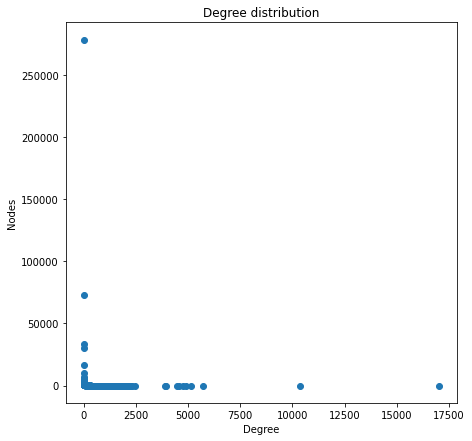

In [7]:
# Obtenim els graus
lista_grados_in = [d for n, d in G.degree()]

# Els veiem en un scatter plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.scatter(*np.unique(lista_grados_in, return_counts=True))
ax.set_title("Degree distribution")
ax.set_xlabel("Degree")
ax.set_ylabel("Nodes")

plt.show()

Obtenim el k-core amb k=1 i comprovem nodes i arestes del resultat.

In [8]:
start = time.time()

sub_g = nx.k_core(G, k=1)
print(nx.number_of_nodes(sub_g))
print(nx.number_of_edges(sub_g))

end = time.time()
print(end - start)

446967
787281
20.5727596282959


Veiem el top 10 nodes amb major grau d'entrada amb pesos.

In [9]:
sorted(list(sub_g.in_degree(weight='weight')), key=lambda node: node[1], reverse=True)[0:15]

[('IgualdadGob', 19979.0),
 ('IreneMontero', 12336.0),
 ('vitoquiles', 6835.0),
 ('lopezdoriga', 5894.0),
 ('emmiartbook', 5156.0),
 ('desaparecidaorg', 5037.0),
 ('MarDGamero', 4845.0),
 ('hsvale_idk0', 4591.0),
 ('arigameplays', 4486.0),
 ('KareenUrilo', 3903.0),
 ('lopezobrador_', 3211.0),
 ('PSOE', 2832.0),
 ('del_machismo', 2797.0),
 ('CaraveoBertha', 2720.0),
 ('DanannOficial', 2650.0)]

## Detecció de comunitats amb CDlib

Calculem les comunitats amb l'algoritme de Leiden.

In [10]:
start = time.time()

leiden_coms = algorithms.leiden(sub_g, weights='weight')

end = time.time()
print(end - start)

16.668531894683838


Veiem el total de comunitats.

In [11]:
print(len(leiden_coms.communities))

12042


Contem els nodes que pertanyen a les primeres 60.

In [12]:
count_nodes = 0
nodes_sub_graf = []
i = 0
for i in range(60):
    count_nodes += len(leiden_coms.communities[i])
print(count_nodes)

404388


Calculem el percentatge que representen aquests nodes respecte al total del graf.

In [13]:
(404388*100)/446967

90.47379336729557

Amb les primeres 60 comunitats obtenim el 90% dels nodes.

Creem ara un subgraf d'aquests nodes.

In [14]:
nodes_sub_graf = [element for sub in leiden_coms.communities[0:60] for element in sub]

# Comprovem
print(len(nodes_sub_graf))

404388


In [15]:
start = time.time()

H = sub_g.subgraph(nodes_sub_graf)

end = time.time()
print(end - start)

0.15062570571899414


Comprovem nodes i arestes.

In [16]:
print(nx.number_of_nodes(H))
print(nx.number_of_edges(H))

404388
749756


In [17]:
(749756*100)/787281

95.23359512042079

Ara calculem les comunitats d'aquest subgraf creat:

In [18]:
start = time.time()

leiden_coms = algorithms.leiden(H, weights='weight')

end = time.time()
print(end - start)

32.458200216293335


In [19]:
print(len(leiden_coms.communities))

99


Aquest serà el graf i les comunitats que analitzarem a Gephi.

Abans d'exportar el graf afegirem la comunitat a la qual pertany cada node com a atribut del node.

Per a fer això primer creem un dict amb els nodes i la seua comunitat:

In [20]:
start = time.time()

leiden_coms_map = leiden_coms.to_node_community_map()

end = time.time()
print(end - start)

0.18353819847106934


Comprovem

In [21]:
leiden_coms_map

defaultdict(list,
            {'RPTLN_': [0],
             'AndyP__': [0],
             'EsposadePercy': [0],
             'GAAB_222': [0],
             'CesMagali': [0],
             'Nacho_Hinojal': [0],
             'emmiartbook': [0],
             'Eslor03_': [0],
             'sandiaspooky': [0],
             'trgrivar': [0],
             'pauulaaact': [0],
             '0RENNN': [0],
             'insonyy_': [0],
             'AX0SWEETHEART': [0],
             'kiwilondo13': [0],
             'AndreaM_ATM': [0],
             'crvts10': [0],
             'YildizMonica': [0],
             'kimuliae': [0],
             'Valiiseleme': [0],
             'veramilagrosok': [0],
             'flashqueen_': [0],
             'magically_m3': [0],
             'SofiaBMercado': [0],
             'yaniramenaa12': [0],
             'moremanzanaress': [0],
             'MadeInDaeguuu': [0],
             'claudiaazamoraa': [0],
             'Pao_Hezzu': [0],
             'adamari_yya': [0],
    

El camp de comunitat és de tipus *list*, el qual entra en conflicte amb la funció *write_graphml()*. Així que canviarem el seu format per a poder exportar el graf sense problemes.

In [22]:
start = time.time()

for node in list(H.nodes()):
    leiden_coms_map[node] = leiden_coms_map[node][0]
    
end = time.time()
print(end - start)

0.6961655616760254


Comprovem.

In [23]:
leiden_coms_map

defaultdict(list,
            {'RPTLN_': 0,
             'AndyP__': 0,
             'EsposadePercy': 0,
             'GAAB_222': 0,
             'CesMagali': 0,
             'Nacho_Hinojal': 0,
             'emmiartbook': 0,
             'Eslor03_': 0,
             'sandiaspooky': 0,
             'trgrivar': 0,
             'pauulaaact': 0,
             '0RENNN': 0,
             'insonyy_': 0,
             'AX0SWEETHEART': 0,
             'kiwilondo13': 0,
             'AndreaM_ATM': 0,
             'crvts10': 0,
             'YildizMonica': 0,
             'kimuliae': 0,
             'Valiiseleme': 0,
             'veramilagrosok': 0,
             'flashqueen_': 0,
             'magically_m3': 0,
             'SofiaBMercado': 0,
             'yaniramenaa12': 0,
             'moremanzanaress': 0,
             'MadeInDaeguuu': 0,
             'claudiaazamoraa': 0,
             'Pao_Hezzu': 0,
             'adamari_yya': 0,
             'violetaxwitch': 0,
             'FDGaldos': 0,
   

Afegim la comunitat com a atribut al node.

In [24]:
start = time.time()

nx.set_node_attributes(H, leiden_coms_map, name="comunidad")

end = time.time()
print(end - start)

0.6801795959472656


Guardem el graf.

In [25]:
try:
    nx.write_graphml(H, "graphml/8m_k1_subgraf_top60.graphml")
except Exception as e:
    print(e)

## Tractament del graf de les comunitats seleccionades amb Gephi

En aquest punt hem tractat el graf anterior a Gephi on hem seleccionat aquelles comunitats amb nodes que es poden relacionar amb Espanya. El que farem a continuació és carregar aquest graf i calcular les comunitats que es creen de la mateixa manera que hem fet abans.

Comencem carregant el graf:

In [38]:
start = time.time()

G = nx.read_graphml("graphml/8m_k1_spain.graphml")

end = time.time()
print(end - start)

10.4829580783844


Comprovem nodes i arestes.

In [39]:
print(nx.number_of_nodes(G))
print(nx.number_of_edges(G))

124434
232118


Obtenim les comunitats amb Leiden:

In [40]:
start = time.time()

leiden_coms = algorithms.leiden(G, weights='weight')

end = time.time()
print(end - start)

5.025554418563843


Comprovem el total de comunitats.

In [41]:
print(len(leiden_coms.communities))

131


Guardem l'atribut comunidad en cada node:

In [42]:
start = time.time()

leiden_coms_map = leiden_coms.to_node_community_map()

end = time.time()
print(end - start)

0.074798583984375


In [43]:
start = time.time()

for node in list(G.nodes()):
    leiden_coms_map[node] = leiden_coms_map[node][0]
    
end = time.time()
print(end - start)

0.05488157272338867


In [44]:
start = time.time()

nx.set_node_attributes(G, leiden_coms_map, name="comunidad")

end = time.time()
print(end - start)

0.18949675559997559


Guardem el nou graf per tractar-lo amb Gephi.

In [45]:
try:
    nx.write_graphml(G, "graphml/8m_k1_spain_coms.graphml")
except Exception as e:
    print(e)